# Tutorial 1 - Reinforcement learning

In this tutorial, we will learn how to implement simple reinforcement learning models and fit them to human behavior.

We'll use a classic experimental paradigm: the **two-armed bandit task**. In this task:
- Participants perform $T$ choices between two options (slot machines)
- The machines have asymmetric reward probabilities: $\mu_{1} \geq \mu_{2}$ (with $0 < \mu_i < 1$).
- These probabilities are **unknown** to the participant
- The goal is to maximize total reward over time

We will use a public dataset from the [Choice Engineer Competition](https://www.nature.com/articles/s41467-019-10825-6). This was a competition for which computational model of behavior could best explain the pattern of responses of many participants playing the two-armed bandit task. (Spoiler: although many models included variants of Q-learning, the winning model did not). The task is presented in the figure below, and the reward scheme corresponds to panel e (where red dots mark whenever one option is rewarded).

### What You'll Learn

By the end of this tutorial, you will:
1. **Understand** three different models of human decision-making
2. **Implement** behavioral analyses to compare model predictions
3. **Apply** these techniques on real data to understand real human behavior

![Alt Text](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-019-10825-6/MediaObjects/41467_2019_10825_Fig1_HTML.png?as=webp)

## Setup: Importing Libraries and Data

Let's start by importing the necessary modules and setting up our computational environment. We'll be working with numerical data, creating visualizations, and implementing optimization algorithms.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets       # interactive display

# Download the custom library - do this manually if not running on google colab
MODULE_NAME = "models.py"
if not os.path.isfile("models.py"):
    MODULE_URL = f'https://raw.githubusercontent.com/MBC_NeuroAI/A1_ReinforcementLearning/A1_ReinforcementLearning/{MODULE_NAME}'
    !wget -O {MODULE_NAME} "{MODULE_URL}"

# set numpy seed to 0
np.random.seed(0)

### 1. Experimental Setup

Before we dive into modeling, let's establish the experimental parameters that define our 2-armed bandit task. These parameters will be used throughout the tutorial to generate synthetic data and test our models.

The dataset is available [here](https://github.com/ohaddan/competition/tree/master/data). Some of the experiments involve complex scheduling, meaning that the probability of rewards for the two slots can change over time and depend on the participant choices, but here we will use the basic static scheduling where these probabilities are fixed over the 100 trials that each subject perform. Over these trials one of the sides (left or right, depending on subject, but fixed within each subject) is *biased*. This means that its associated probability of this side is higher than the other one (which we call unbiased response). Specifically the reward probability of the unbiased and biased sides are respectively  $\mu_{1} = 0.17$ and $\mu_{2} = 0.33$. This implies that half of the times none of the side were actually rewarded.

The code belows downloads the csv files from all 97 subjects, merge them in a single dataframe and shows only the fields useful for the tutorial:
- `subject` is the ID of the subject, from 1 to 97
- `trial` is the index of each trial (from 1 to 100)
- `available_rewards` is a list of two values, representing whether choice on the unbiased side and biased side are rewarded. Note that in around 50% of trials both values are 0, meaning that the participant will not get a reward irrespective of their choice
- `choice` is the actual choice of the participant: 0 for the unbiased and 1 for the biased choice
- `reward` is the reward they received (0 or 1).

In [3]:
# those two lines are to make sure it works on Colab
import sys
sys.modules.pop("models",None)

from models import import_choice_engineer_competition_data

df, Nsubject = import_choice_engineer_competition_data()
df.head()

loaded data from  97  participants ( 9664  trials in total)


,subject,trial,available_rewards,choice,reward
0,1,1,"(0, 1)",1,1
1,1,2,"(0, 1)",0,0
2,1,3,"(0, 0)",1,0
3,1,4,"(0, 1)",0,0
4,1,5,"(0, 0)",1,0


Let's first check how the behavior of participants evolve within their session. For this we plot the proportion of correct responses as a function of trial index. Here we call *correct responses* when the participant selected the biased choice: although this response is not always rewarded, selecting it is always the optimal thing to do, because the probability of getting a reward is higher.

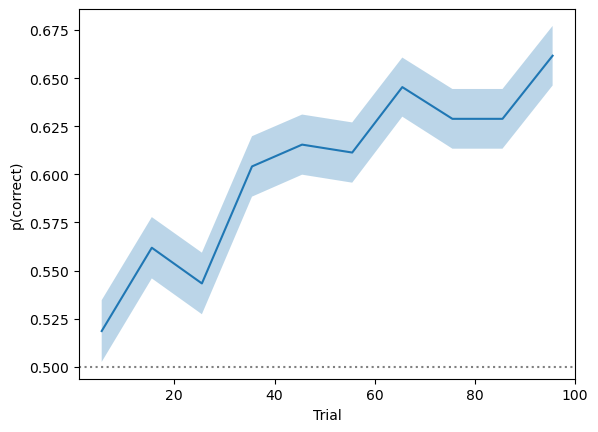

In [57]:
def plot_correct(df, vars=['choice'], label=['']):
    plt.figure();
    df['trial'] = ((df['trial'] - 1) // 10)*10 + 5.5
    for v,lbl in zip(vars,label):
        # Group by trial and compute mean and SEM
        grouped = df.groupby('trial')[v].agg(['mean', 'sem'])
        
        # add line
        plt.plot(grouped.index, grouped['mean'], '-', label=lbl)
        
        # Fill the area between mean - SEM and mean + SEM
        plt.fill_between(
            grouped.index,
            grouped['mean'] - grouped['sem'],
            grouped['mean'] + grouped['sem'],
            alpha=0.3);
    
    plt.axhline(y=0.5, color='gray', linestyle=':', linewidth=1.5);
    if len(label)>1:
        plt.legend();
    plt.xlabel('Trial')
    plt.ylabel('p(correct)');

plot_correct(df)

**Q1 - What does this plot tell us about participant behavior?**

*Copy you response on the Aula Global quiz*

### 2. Three Models of Human Decision-Making

Now we'll explore three different computational models that capture different theories about how humans make decisions in uncertain environments. Each model represents a different cognitive strategy that people might use when faced with the 2-armed bandit task.

We will consider three different computational models that represent distinct hypotheses about human decision-making:

#### Model 1: **Choice Kernel**
- **Core idea**: Tendency to repeat recent actions regardless of outcomes
- **Mechanism**: Builds up "momentum" for recently chosen actions
- **Parameters**: Kernel learning rate $\alpha_{CK}$ and temperature $\beta_{CK}$
- **Psychological insight**: Captures perseveration and habit formation
- **Real-world example**: Like having a favorite restaurant you keep going to out of habit, even when the food quality varies

#### Model 2: **Noisy Win-Stay-Lose-Shift (WSLS)**
- **Core idea**: Simple heuristic strategy
- **Mechanism**: If the last choice was rewarded → repeat it; if not → switch to the other option
- **Randomness**: Occasionally explores randomly (parameter: $\epsilon$)
- **Psychological insight**: Represents basic associative learning without sophisticated value computation
- **Real-world example**: Like a person who sticks with a restaurant if they had a good meal, switches if they had a bad meal

#### Model 3: **Rescorla-Wagner Learning**
- **Core idea**: Sophisticated value learning based on prediction errors
- **Mechanism**: Maintains estimates of each option's value, updates based on reward prediction error
- **Parameters**: Learning rate $\alpha_{RW}$ (how fast you learn) and softmax temperature $\beta_{RW}$ (how deterministic your choices are)
- **Psychological insight**: Represents gradual learning and memory integration
- **Real-world example**: Like carefully tracking your experiences with different restaurants and slowly updating your preferences

## Initialize the Models

The models are already implemented in `models.py`, which are imported below. Notice how each model inherits from a base class and implements the same interface (simulate, fit, etc.) - this is good software engineering practice that makes our code modular and extensible.

In [58]:
from models import WinStayLoseSwitch, RescorlaWagner, ChoiceKernel

## Simulate the Models

Before we can fit models to real data, we need to understand what behavior each model predicts. Simulation allows us to:
- Test our implementation
- Understand parameter effects
- Generate ground truth data for validation
- Explore the model's behavioral repertoire

**Implementation**: The `simulate()` function generates synthetic choice sequences for each model. To simulate the model, we must pass on the sequence of trials as well as the choice of the parameteres for the given model.

We will simulate all models on the exact same paradigm: the sequence of the first participant in the dataset. The sequence is uniquely defined by the availability of rewards for each of the 100 trials in the sequence, which is represented by the `available_rewards` array. Let's convert is to a two-column numpy array.

In [59]:
all_available_rewards = np.array(df['available_rewards'].tolist())
available_rewards = all_available_rewards[df.subject==1]
available_rewards[:12,:]

array([[0, 1],
       [0, 1],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 1],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1]])

### The Choice kernel model
This model stores the *weights* $w_i$ for each possible option $i$. The weight on an option is updated everytime it is selected (and irrespective of the feedback), following: $w_i \leftarrow w_i + \alpha (1- w_i)$. On each trial, an option is selected based on this weight, using a softmax rule such that larger weights increase the chance of getting selected: $p(a_t=i)= \exp(\beta w_ i) / \sum_j \exp (\beta w_j)$<br>
This model takes two parameters:
- $\alpha$ is the **learning rate** parameter. The larger it is, the larger is the update of the choice kernel after each choice.
- $\beta$ is the **inverse temperature** parameter (in the softmax). Large beta values means that the model is close to deterministic, following the response with larges choice kernel on every trial. Small beta values makes the model more random and relying less on the choice kernels <br>
Run the widget below. Everytime we change the slider, a new simulation is run with the selected parameters. The curves indicate the dynamics of options weights $w_i$. Symbols on top indicate which option is selected on every trial (triangle: positive reward; cross: negative reward).

In [60]:
@widgets.interact(
    alpha = widgets.FloatSlider(0.20, min=0.0, max=.5, step=0.02), # default, min and max values for learning rate param
    beta = widgets.FloatSlider(1, min=0.0, max=5.0), # defauly, min and max values for temperature parameter
    display_trials = widgets.FloatSlider(30, min=10, max=100, step=1))

def plot_choice_kernel(alpha, beta,display_trials):
    # use random seed to get always the same simulation for given set of trials
    np.random.seed(100)
    
    # simulate Choice Kernel model with given parameters
    ck_model = ChoiceKernel()
    a_CW, r, CK = ck_model.simulate(available_rewards, alpha=alpha, beta=beta)

    
    T = len(a_CW)
    side_color = ['b','r']
    side_labels = ['unbiased','biased']
    
    plt.figure;
    # plot values of choice kernels
    for a in range(2):
        plt.plot(CK[:,a],color=side_color[a], label=side_labels[a]);
    
    # Plot choices and outcomes
    for i in range(T):
        marker = '^' if r[i] == 1 else 'x'
        plt.scatter(i, 1.2+.2*a_CW[i], marker=marker, color=side_color[a_CW[i]], s=30)
    plt.yticks([0,0.5, 1,1.2,1.4],['0','0,5','1','unbiased','biased'])
    plt.title('Simulated Choice Kernel')
    plt.ylim([0,1.5])
    plt.xlim((-.5,display_trials));
    plt.legend();
    
    plt.xlabel('trial index')
    plt.ylabel('action values')
    
    print("Number of collected rewards:", np.sum(r))
    print("Number of correct choices:", np.sum(a_CW==1))

    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=0.2, description='alpha', max=0.5, step=0.02), FloatSlider(value=1.0, …

**Q2 - Describe here how the Choice Kernel model behaves for different values of the parameters.**

*Copy you response on the Aula Global quiz*

## Win-Stay Lose-Switch model
This model does take into account feedback to try to improve performance, but in a rather crude way. Simply, if the selected action $a_t$ is rewarded, then the model will likely repeat on the next trial (with a probability larger than 0.5). If it is not rewarded, it is more likely to alternate. In equations:
- $p(a_{t+1}=a_{t}) = 1 - \epsilon/2$ if trial $t$ is rewarded
- $p(a_{t+1}=a_{t}) = \epsilon/2$ if trial $t$ is unrewarded <br>
$0 < \epsilon < 1$ is the unique parameter of the model, regulating the strength of this policy.
Again, run the widget below to explore how the behavior of this model depends on the value of the parameter.

In [61]:
@widgets.interact(
    epsilon = widgets.FloatSlider(0.20, min=0.0, max=1, step=0.02), # default, min and max values for epsilon param
    display_trials = widgets.FloatSlider(40, min=10, max=100, step=1))

def plot_WSLS(epsilon,display_trials):
    # use random seed to get always the same simulation for given set of trials
    np.random.seed(100)
    
    # simulate WSLS with given parameters
    wsls_model = WinStayLoseSwitch()
    a_WSLS, r, p_WSLS = wsls_model.simulate(available_rewards, epsilon=epsilon)

    T = len(a_WSLS)
    side_color = ['b','r']

    plt.figure;
    # plot values of choice probability
    for a in range(2):
        plt.plot(p_WSLS[:,a],color=side_color[a]);
    
    # Plot choices and outcomes
    for i in range(T):
        marker = '^' if r[i] == 1 else 'x'
        plt.scatter(i, 1.2+.2*a_WSLS[i], marker=marker, color=side_color[a_WSLS[i]], s=30)
    plt.yticks([0,0.5, 1,1.2,1.4],['0','0,5','1','unbiased','biased'])
    plt.title('Simulated WSLS model')
    plt.ylim([0,1.5])
    plt.xlim((-.5,display_trials));
    
    plt.xlabel('trial index')
    plt.ylabel('choice probability')
    
    print("Number of collected rewards:", np.sum(r))
    print("Number of correct choices:", np.sum(a_WSLS==1))

    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=0.2, description='epsilon', max=1.0, step=0.02), FloatSlider(value=40.…

**Q3 - Describe how the WSLS model behaves, depending on the value of its parameter.**

*Copy you response on the Aula Global quiz*

### the Rescorla-Wagner model

The Rescorla-Wagner model implements a fundamental principle of learning: we learn from prediction errors. Here's how it works:

**The Rescorla-Wagner learning rule**:
- Start with initial value estimates: $Q_0 = [0.5, 0.5]$ (neutral expectations)
- For each trial $t$:
  1. **Choice**: Select action based on softmax: $P(a) = \frac{e^{\beta Q_a}}{\sum_{a'} e^{\beta Q_{a'}}}$
  2. **Outcome**: Observe reward $r_t$ 
  3. **Learning**: Update value with prediction error: $Q_a \leftarrow Q_a + \alpha(r_t - Q_a)$. If the action is rewarded ($r_t=1$), then $Q_a$ increases, otherwise it decreases. $Q_a$ is actually the prediction of getting a reward for action $a$. The model learns from **reward prediction errors** $r_t - Q_a$, not just outcomes.

The model takes two parameters:
- $\alpha$ is the **learning rate** (0 = no learning, 1 = only remember last outcome)
- $\beta$ is the **inverse temperature** controlling choice determinism (0 = random, ∞ = always choose best)

**Complete the implementation of the simulation and fitting functions for the Rescorla-Wagner model**.

In [62]:
from models import RLModel

class RescorlaWagner(RLModel):
    def simulate(self, available_rewards, alpha, beta):
        # initial values for Q: 0.5 for each option
        Q = np.array([0.5, 0.5])
        
        a, r = [], []
        T = available_rewards.shape[0] # number of trials
        Qall = np.empty((T,2))
        delta_all = np.empty(T)
        
        # loop through all trials
        for t in range(T):
            
            # compute probability for selecting each option based on Q-values
            # !!! fill the line and copy on quiz
            p = ???

            # select action following these probabilities
            ch = np.random.choice(len(p), p=p)

            # corresponding outcome
            oo = available_rewards[t,ch]

            # update Q-value for selected choice based on reward prediction error
            # !!! fill the line and copy on quiz
            Q[ch] ???

            Qall[t,:] = Q
            delta_all[t] = delta
            
            # append to lists
            a.append(ch)
            r.append(oo)

        return np.array(a), np.array(r), Qall

    def negLogLikelihood(self, pars, a, r):
        alpha, beta = pars

        # initial values for Q
        Q = np.array([0.5, 0.5])
        choice_p = []
        T = len(a) # number of time steps
        
        #loop through all trials
        for t in range(T):
            # probability of choices
            betaQ_rel = beta * Q - np.max(beta * Q) # we substract a fixed value for numerical stability
            p = np.exp(betaQ_rel) / np.sum(np.exp(betaQ_rel))
            choice_p.append(p)

            # update Q-values based on outcome
            delta = r[t] - Q[a[t]]
            Q[a[t]] += alpha * delta

        #log-likelihood for individual trials (we add small values to avoid infinite if p is 0 - akin to including lapses)
        LLH = np.sum(np.log(np.array(choice_p) + 1e-5))
        return -LLH 

    def initial_parameters(self):
        return [np.random.random(), np.random.exponential()]

    def parameter_bounds(self):
        return [(0, 1), (0, np.inf)]

Now you can play with the widget. Note that we have added a panel below with the value of the **reward prediction error** - make sure you understand its value across trials, as this drives updating of action values.

In [63]:
@widgets.interact(
    alpha = widgets.FloatSlider(0.20, min=0.0, max=.5, step=0.02), # default, min and max values for learning rate param
    beta = widgets.FloatSlider(0.5, min=0.0, max=20.0), # defauly, min and max values for temperature parameter
    display_trials = widgets.FloatSlider(40, min=10, max=100, step=1))

def plot_rescorla_wagner(alpha, beta,display_trials):
    # use random seed to get always the same simulation for given set of trials
    np.random.seed(100)
    
    # simulate Rescorla-Wagner with given parameters
    rw_model = RescorlaWagner()
    # a_RW is the sequence of choices, r is the sequence of rewards, Q is the table of Q-values on every trial
    a_RW, r, Q = rw_model.simulate(available_rewards, alpha=alpha, beta=beta)
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
    T = len(a_RW) # number of trials
    side_color = ['b','r']
    
    for a in range(2):
        ax1.plot(Q[:,a],color=side_color[a]);
    
    # Plot Rescorla-Wagner
    for i in range(T):
        marker = '^' if r[i] == 1 else 'x'
        ax1.scatter(i, 1.2+.2*a_RW[i], marker=marker, color=side_color[a_RW[i]], s=30)
    ax1.set_yticks([0,0.5, 1,1.2,1.4],['0','0,5','1','unbiased','biased'])
    ax1.set_title('Simulated Rescorla-Wagner')
    ax1.set_ylim([0,1.5])
    ax1.set_xlim((-.5,display_trials));
    
    ax1.set_ylabel('Q-values')

    # compute reward prediction error
    prevQ = np.vstack(([0.5, 0.5], Q[:-1])) # Q-value on each trial before updating
    Q_chosenaction = prevQ[np.arange(len(a_RW)), a_RW] # Q-value for chosen action (before updating)
    delta = r - Q_chosenaction # reward prediction error
    
    markerline, stemlines, baseline =ax2.stem(delta);
    
    # Build color list based on boolean mask
    colors = ['blue' if aa==1 else 'red' for aa in a_RW]

    # Apply colors to stems
    stemlines.set_colors(colors)
    
    ax2.set_xlim((-.5,display_trials));
    ax2.set_xlabel('trial index');
    ax2.set_ylabel('R.P.E.');
  
    print("Number of collected rewards:", np.sum(r))
    print("Number of correct choices:", np.sum(a_RW==1))

    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=0.2, description='alpha', max=0.5, step=0.02), FloatSlider(value=0.5, …

**Q4 - Describe how the RW model behaves, depending on the value of its parameters.**

*Copy you response on the Aula Global quiz*

#  Behavioral Analysis: Understanding Model Predictions

**Learning objective**: Learn to analyze and visualize model behavior to understand what makes different models distinct.

**Why behavioral analysis?** Before fitting models to real data, we need to understand what patterns each model predicts. This helps us:
- Identify which models are actually different from each other
- Understand what behavioral signatures to look for in real data
- Design better experiments that can distinguish between models
- Build intuition about model behavior

**The key insight**: If two models predict identical behavior, there's no point in comparing them. Good computational modeling requires models that make different, testable predictions.

# Win-Stay-Lose-Shift Analysis

**What is WSLS analysis?** Win-Stay-Lose-Shift analysis is a fundamental tool in behavioral neuroscience that measures how much a decision-maker's choices depend on the outcomes of their previous actions.

**The measurement**: We calculate:
- $p(stay|win)$: Probability of repeating an action after it was rewarded
- $p(stay|lose)$: Probability of repeating an action after it was unrewarded

This analysis reproduces **Figure 1** from Wilson & Collins' [Ten simple rules for the computational modeling of behavioral data](https://elifesciences.org/articles/49547) (*eLife*, 2019), demonstrating how different models produce distinct behavioral signatures.

### Implementing WSLS Analysis

**Complete the function `compute_stay_probabilities()` below** that calculates WSLS measures from choice data (either experimental or simulated).

**Algorithm**:
1. For each trial $t > 1$:
   - Determine if the participant "stayed" (chose the same action as trial $t-1$)
   - Check if the previous trial was rewarded or unrewarded
2. Calculate the probabilities using the implemented function below:

In [64]:
def compute_stay_probabilities(actions, rewards, simulated_actions=[]):
    """Compute probability of stay given win/lose."""
    # action from previous trial (nan for first trial)
    actions_last = np.hstack([np.nan, actions[:-1]])

    # reward from previous trial
    rewards_last = np.hstack([np.nan, rewards[:-1]])
    
    # boolean array: true if action is repeated from previous trial
    if len(simulated_actions)==0:
        # no simulations
        stay = np.array(actions_last == actions).astype(float)
    else:
        # simulations (test if simulated action matches previous action from participant)
        stay = np.array(actions_last == simulated_actions).astype(float)

    # compute the probability of staying when previous trial was rewarded
    win_stay = np.nanmean(stay[rewards_last == 1])

    # compute the probability of staying when previous trial was not rewarded
    lose_stay = np.nanmean(stay[rewards_last == 0])
    
    return lose_stay, win_stay

Now we will compare the WSLS pattern for our different models. To make results more robust, we will simulate each model multiple times (110, why not) and average over simulations.

In [65]:
# define a function to simulate the models and collect data
def simulate_model_multiple_times(model, num_reps, available_rewards, **params):
    actions, rewards = [], []
    for _ in range(num_reps):
        a, r, _ = model.simulate(available_rewards, **params)
        actions.append(a)
        rewards.append(r)
    return actions, rewards

# Simulate models, each 110 times
num_repetitions = 110

#initialize models
wsls_model = WinStayLoseSwitch()
rw_model = RescorlaWagner()
ck_model = ChoiceKernel()

# run simulations
a_wsls, r_wsls = simulate_model_multiple_times(wsls_model, num_repetitions, available_rewards, epsilon=0.1)
a_rw, r_rw = simulate_model_multiple_times(rw_model, num_repetitions, available_rewards, alpha=0.1, beta=5)
a_ck, r_ck = simulate_model_multiple_times(ck_model, num_repetitions, available_rewards, alpha=0.1, beta=3)

In [66]:
# Calculate WSLS for each model
model_actions = [a_wsls, a_rw, a_ck]
model_rewards = [r_wsls, r_rw, r_ck]
model_names = ['WSLS', 'Rescorla-Wagner', 'Choice kernel']

wsls_probs = []

# Loop over all three models
for actions, rewards in zip(model_actions, model_rewards):
    wsls_all_simul = [compute_stay_probabilities(actions[n], rewards[n]) for n in range(num_repetitions)]
    
    #compute mean and s.e.m. over simulations
    wsls_mean = np.mean(wsls_all_simul, axis=0)
    wsls_probs.append(wsls_mean)


Now let's **plot WSLS behavior** as a function of previous reward (1 for rewarded, 0 for unrewarded).

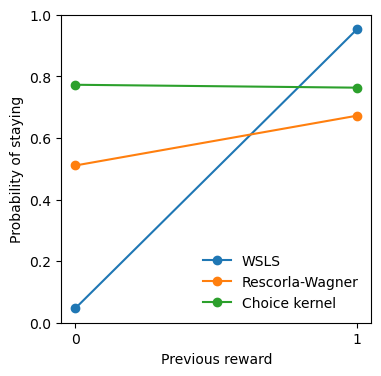

In [67]:
# Plot WSLS as a function of previous reward
plt.figure(figsize=(4, 4))
for i, prob in enumerate(wsls_probs):
    plt.plot([0, 1], prob, 'o-', label=model_names[i])
plt.xlabel('Previous reward')
plt.ylabel('Probability of staying')
plt.xticks([0, 1])
plt.legend(frameon=False)
plt.ylim(0, 1);

**Q5 - Interpret the pattern for each model**

*Copy you response on the Aula Global quiz*

## Parameter Effects Analysis: Understanding the Rescorla-Wagner Model

**Learning objective**: Understand how model parameters affect behavior and performance.

**Why study parameter effects?** Different parameter values lead to different behavioral patterns. Understanding these relationships helps us interpret fitted parameters meaningfully.

Here we systematically vary the Rescorla-Wagner parameters ($\alpha$ and $\beta$) and measure how they affect performance in early vs. late trials.

**Key questions**:
- How does learning rate ($\alpha$) affect early learning vs. asymptotic performance?
- How does temperature ($\beta$) interact with learning rate?
- Are there optimal parameter combinations?
- What do these patterns tell us about the explore-exploit tradeoff?

We will repeatedly perform a grid search over different parameter values (with multiple simulations for each) and store the mean $p(correct)$ across trials for each grid point and repetition.

In [68]:
# Parameter grid search for Rescorla-Wagner model
alphas = np.linspace(0.02, 1, 6)
betas = np.array([1, 2, 5, 10, 20])

In [69]:
# Let's first use only 10 simulations for each parameter combination. When your code works, increase to 500.
num_reps = 500

# Initialize arrays to collect data
correct = np.zeros((len(alphas), len(betas), num_reps))
correct_early = np.zeros((len(alphas), len(betas), num_reps))
correct_late = np.zeros((len(alphas), len(betas), num_reps))

# Evaluation loop: grid-search over alpha and beta parameters for a large number of simulations
# on which you will then average.
for n in range(num_reps):
    for ai, alpha in enumerate(alphas):
        for bi, beta in enumerate(betas):
            # simulate the model with given parameters
            actions, rewards,_ = rw_model.simulate(available_rewards, alpha, beta)

            # correct choice is defined as the choice where the maximum number of rewards are available
            correct_choice = np.argmax(np.sum(available_rewards,axis=0))

            # compute the proportion of correct choices in all trials, then in the first 10, then in the last 10
            correct[ai, bi, n] = np.mean(actions == correct_choice)
            correct_early[ai, bi, n] = np.mean(actions[:10] == correct_choice)
            correct_late[ai, bi, n] = np.mean(actions[-10:] == correct_choice)

Now **let's plot $p(correct)$ as a function of $\alpha$ and $\beta$**, separately for early and  late trials. Plot different levels of $\alpha$ on the x-axis and use different curves for $\beta$ levels.

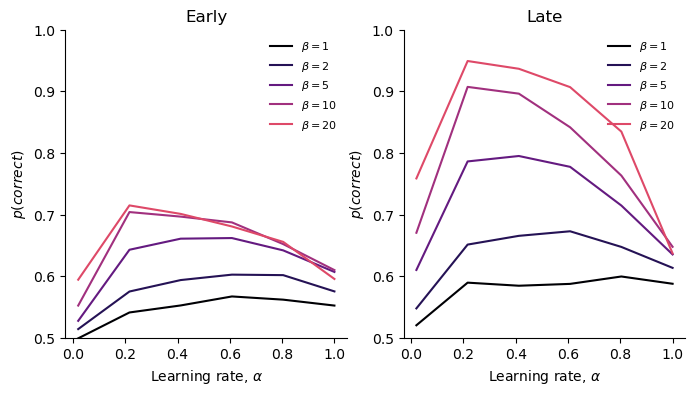

In [70]:
colors = plt.get_cmap('magma')(np.linspace(0, 0.6, len(betas)))

# average performance in early and late trials over different simulations (with same parameter set)
correct_early_avg = np.mean(correct_early, axis=-1)
correct_late_avg = np.mean(correct_late, axis=-1)


plt.figure(figsize=(8, 4), dpi=100)

# Subplot for performance in early trials
plt.subplot(1, 2, 1)
plt.title('Early')
for ei, early in enumerate(correct_early_avg.T):
    plt.plot(alphas, early, color=colors[ei], label=rf'$\beta = {betas[ei]:.0f}$')
plt.xlabel(r'Learning rate, $\alpha$')
plt.ylabel(r'$p(correct)$')
plt.legend(frameon=False, fontsize=8)
plt.ylim(0.5, 1)

# Subplot for performance in late trials
plt.subplot(1, 2, 2)
plt.title('Late')
for li, late in enumerate(correct_late_avg.T):
    plt.plot(alphas, late, color=colors[li], label=rf'$\beta = {betas[li]:.0f}$')
plt.xlabel(r'Learning rate, $\alpha$')
plt.ylabel(r'$p(correct)$')
plt.legend(frameon=False, fontsize=8)
plt.ylim(0.5, 1)

sns.despine()

**Q6 - How does performance change as a function of alpha and beta parameter values, for early and late trials?**

*Copy you response on the Aula Global quiz*

# Test models on experimental data

## Fitting models to individual participants

We will now fit the different models to each participant data. What we should do in a real research project would be to perform parameter recovery first. Parameter recovery implies fitting our models on synthetic data and check that the fitting procedure accurately recovers parameter estimates. This step (similar in spirit to power analysis) is essential for validating your computational modeling approach (check Wilson & Collins paper mentioned above for more details).

Each model can be fitted on experimental data by calling the `fit()` method for that model, which takes as inputs the sequence of actions and rewards for a given participant. We will not focus on the goodness of fit here, but you should take a moment to look at the specification in `.fit()` and `likelihood()` methods of the model in `models.py`.
**Complete the code below to fit all three models on each participant, and simulate the fitted model on participant data.** We will later use these simulations to test whether each model captured participant behavior.

In [71]:
# create variables from simulated choices
df['choice_RW'] = -1
df['choice_CK'] = -1
df['choice_WSLS'] = -1
Nmodel = 3
BIC = np.empty((Nsubject,Nmodel))

# store fitted parameters for each model in these lists
all_params_rw = []
all_params_ck = []
all_params_wsls = []

for n in range(Nsubject):
    # mask with trials for given subject (warning subject ID start at 1)
    mask = df.subject==n+1

    # get sequences of choices and rewards for this participant
    choice_participant = df.choice[mask].values
    reward_participant = df.reward[mask].values

    # fit models to this participant data (CK, WSLS and RW)
    BIC[n,0], params_ck, LLH_ck = ck_model.fit(choice_participant, reward_participant)
    BIC[n,1], params_wsls, LLH_wsls = wsls_model.fit(choice_participant, reward_participant)
    BIC[n,2], params_rw, LLH_rw = rw_model.fit(choice_participant, reward_participant)
  
    # now, simulate participant data with fitted parameters, with exact same available rewards as participant
    df.loc[mask, 'choice_CK'], _, _ = ck_model.simulate(all_available_rewards[mask], alpha=params_ck[0], beta=params_ck[1])
    df.loc[mask, 'choice_WSLS'], _ , _= wsls_model.simulate(all_available_rewards[mask], epsilon=.01) #params_wsls[0])
    df.loc[mask, 'choice_RW'], _, _ = rw_model.simulate(all_available_rewards[mask], alpha=params_rw[0], beta=params_rw[1])

    all_params_ck.append(params_ck)
    all_params_wsls.append(params_wsls)
    all_params_rw.append(params_rw)

# turn lists into arrays
all_params_ck = np.array(all_params_ck)
all_params_wsls = np.array(all_params_wsls)
all_params_rw = np.array(all_params_rw)

## Comparing fitted model to experimental data



### Learning over the session
Let's first check whether each of the fitted models captures the gradual and limited improvement of participant performance over the session.

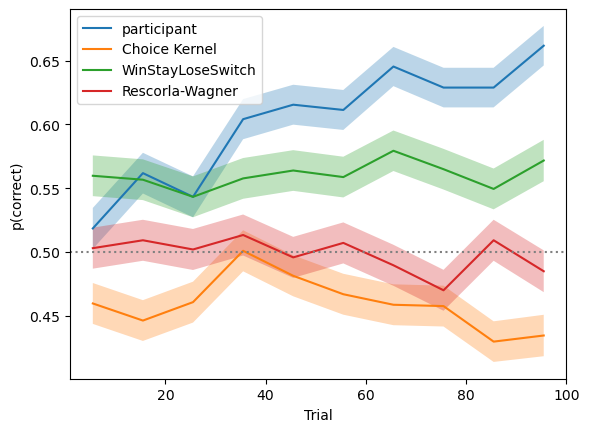

In [72]:
# fields for the variables representing experimental/simulated choices
variable_names = ['choice','choice_CK','choice_WSLS','choice_RW']

# corresponding labels
variable_label = ['participant','Choice Kernel','WinStayLoseSwitch','Rescorla-Wagner']
nVariable = 4

plot_correct(df, vars=variable_names, label=variable_label)

**Q7 - Interpret the plot.**

*Copy you response on the Aula Global quiz*

## Win-stay lose-switch behavior

Now let's compare the win-stay lose-switch behavior in participants with that of fitted models.

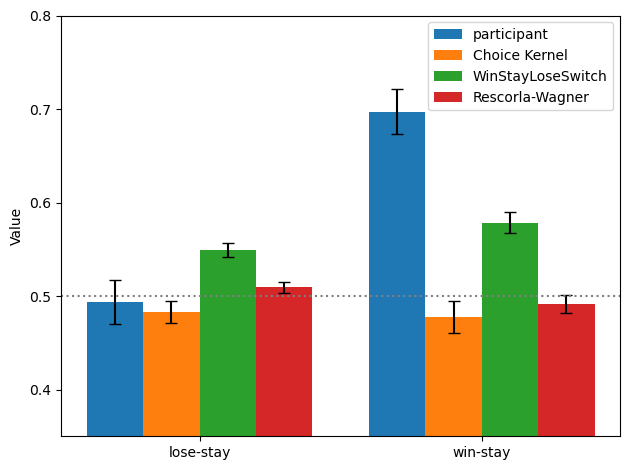

In [73]:
wsls_participant = []
for m in range(nVariable):
    wsls_participant.append(np.empty((Nsubject,2)))

for n in range(Nsubject):
    # mask with trials for given subject
    mask = df.subject==n+1

    # compute win-stay and lose-stay on experimental and simulated data
    reward_participant = df.reward[mask].values
    for m, var in enumerate(variable_names):
        choice_participant = df['choice'][mask].values
        simulated_participant = df[var][mask].values
        wsls_participant[m][n,0], wsls_participant[m][n,1] = compute_stay_probabilities(choice_participant, reward_participant, simulated_participant)

# compute mean and s.e.m. over participants
wsls_means = [a.mean(axis=0) for a in wsls_participant]
wsls_sem = [a.std(axis=0, ddof=1) / np.sqrt(a.shape[0]) for a in wsls_participant]

# Plot
plt.figure()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bar_width = 0.2
for i in range(nVariable):
    plt.bar(
        np.arange(2) + i * bar_width,
        wsls_means[i],
        yerr=wsls_sem[i],
        width=bar_width,
        capsize=4,
        label=variable_label[i],
        color=colors[i]
    )

plt.xticks(np.arange(2) + bar_width * (nVariable - 1) / 2, ['lose-stay', 'win-stay'])
plt.ylabel('Value')
plt.ylim((.35,.8))
plt.legend()
plt.tight_layout()
plt.axhline(y=0.5, color='gray', linestyle=':', linewidth=1.5);


**Q8 - Interpret. Explain the differences.**

*Copy you response on the Aula Global quiz*

## Model comparison
Finally, we will make formal model comparison using the Bayesian Information Criterion to test which model better accounts for each participant data. `BIC` is an array where each row stands for one participant, and each column for a given model.
Because BIC is a relative measure, we will first **compute $\Delta BIC$ as the difference between the BIC of a given model and given participant with the BIC of a reference model** for the same participant. Here we will use the Choice Kernel model as reference (first column in `BIC`). So by definition the $\Delta BIC$ for the CK model will be null for all participants.

In [74]:
Delta_BIC = BIC - BIC[:, [0]]

Now let's plot these values as a violin plot. Positive values of $\Delta BIC$ indicate that the model performs worse than the reference model for this given participant, while negative values indicate that it captures this participant choices better.

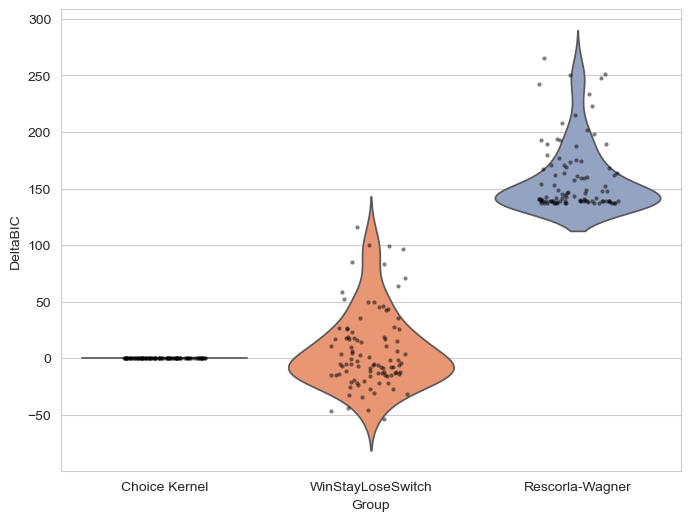

In [75]:
model_label = variable_label[1:]
df_plot = pd.DataFrame({
    'DeltaBIC': Delta_BIC.transpose().flatten(), # np.concatenate([, array2]),
    'Group': [item for item in model_label for _ in range(Nsubject)]
})

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')

# Create violin plots
ax = sns.violinplot(x='Group', y='DeltaBIC', data=df_plot, inner=None, hue='Group',palette='Set2',legend=False);

# Add jittered points
sns.stripplot(    x='Group', y='DeltaBIC', data=df_plot,
    jitter=0.2,  # Horizontal jitter
    size=3,      # Size of points
    color='black',
    alpha=0.5    # Transparency
);

**Let us also count the number of participants supporting each model** (i.e. where BIC score is lowest).

In [76]:
winning_model = np.argmin(BIC, axis=1)
_, winning_counts = np.unique(winning_model, return_counts=True)
for w, m in zip(winning_counts, model_label):
    print("number of participants supporting ", m, ":", w)

number of participants supporting  Choice Kernel : 44
number of participants supporting  WinStayLoseSwitch : 53


**Q9 - Interpret: which model better captures participant behavior?**

*Copy you response on the Aula Global quiz*